<a href="https://colab.research.google.com/github/o93/bayesian-ab/blob/main/BeyesianCategory_PyMC3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

カテゴリ変数の分析を行うことができます．


1. githubにて，↑のOpen in Colabボタンを押して開きます
1. 必要な数だけ選択数を入力します
1. 期待値を求めたいときは，重みを同じ数入力します（任意
1. HDIのしきい値を入力します（任意
    - 例えば90%の確率でHDIを出したい場合は，`0.9`と入力します
1. サンプルサイズを入力します（任意
    - サンプリングを多くすると処理に時間を要しますが，判定のブレが少なくなります
1. 各セルの右上に表示されている▶を順番に押していきます
    - 上部メニューのランタイムから「すべてのセルを実行」なら一度にすべて実行でき

## 準備

In [1]:
!pip install pymc3
!pip install japanize-matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 12.4 MB/s 
     |████████████████████████████████| 1.8 MB 65.2 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=3470747172fdf1c873cae046b6ec612cb02c06cfef6b78ea0c55fa41c892ea72
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.1 MB 11.7 MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120275 sha256=8fe79a66c66a2911fa435d35ec1016534123377854a37a30e31c7c450ad04115
  Stored in directory: /root/.cache/pip/wheels/83/97/6b/e9e0cde099cc40f972b8dd23367308f7705ae06cd6d4714658
Successfully built japanize-matplotlib


# 入力と実行

サンプリング




サマリー


,総数,選択数,割合,HDI下限値,HDI上限値
選択1,185,25,0.135135,0.095556,0.176729
選択2,185,45,0.243243,0.191221,0.292737
選択3,185,31,0.167568,0.122392,0.211140
選択4,185,78,0.421622,0.356287,0.474853
選択5,185,6,0.032432,0.014429,0.057754




誤差


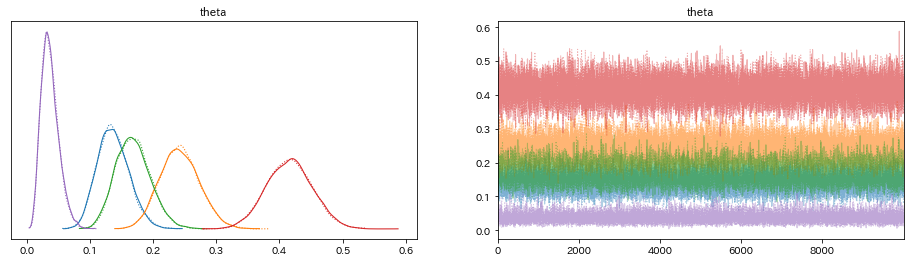

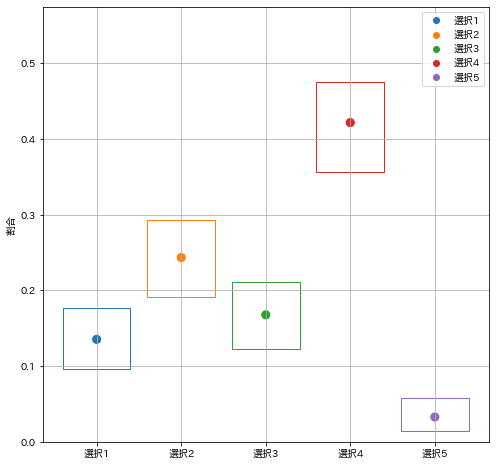

In [20]:
from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
import pymc3 as pm
import numpy as np
import pandas as pd

import warnings
warnings.simplefilter('ignore')

#@markdown 値のリスト（例:アンケートの各選択回答数，レビューの星の選択数）を入力
values = (25, 45, 31, 78, 6) #@param {type:"raw"}
n = np.array(values)

#@markdown 重みリスト（期待値を求めるための重み 例: レビューの星の数）を入力 オプション
weights = (1, 2, 3, 4, 5) #@param {type: "raw"}

#@markdown 重複可（複数回答可）のときだけ総数を入力，そうでないときは"0" オプション
all_size = 0 #@param {type:"integer", min:1}

#@markdown HDIのしきい値を入力
threshold = 0.9 #@param {type:"number", min:0.0, max:1.0}

#@markdown サンプルサイズを入力
sample_size = 10000 #@param {type:"integer", min:100, max:1000000}

data = []

print('サンプリング')
with pm.Model() as model:
    if all_size is None or all_size <= 0:
        theta = pm.Dirichlet('theta', a=np.ones(n.shape[0]))
        obs = pm.Multinomial('AB', p=theta, n=n.sum(), observed=n)
    else:
        theta = pm.Uniform('theta', lower=0, upper=1, shape=n.shape[0])
        obs = pm.Binomial('AB', p=theta, n=all_size, observed=n)

    trace = pm.sample(sample_size, chains=2)

    pm.traceplot(trace, figsize=(16, 4))

print()
print()
print('サマリー')

index = [f'選択{i + 1}' for i in range(n.shape[0])]
df = pd.DataFrame(n, index=index, columns=['選択数'])
all_size = df['選択数'].sum() if all_size is None or all_size <= 0 else all_size
df['総数'] = all_size
df = df[['総数', '選択数']]
df['割合'] = df['選択数'] / all_size

df[['HDI下限値', 'HDI上限値']] = [pm.hdi(trace['theta'][:, i], hdi_prob=threshold) for i in range(n.shape[0])]
display(df)

print()
print()
print('誤差')

width_size = round(n.shape[0] * 1.5)
plt.figure(figsize=(width_size, 8))
sns.scatterplot(x=df.index, y=df['割合'], hue=df.index, s=100)
plt.bar(x=df.index, height=df['HDI上限値'] - df['HDI下限値'], bottom=df['HDI下限値'], fill=False, edgecolor=sns.color_palette(n_colors=n.shape[0]))
plt.grid(True)
plt.ylim((0, df['HDI上限値'].max() + 0.1))
plt.show()

# 期待値

,期待値,HDI下限値,HDI上限値
0,2.973605,2.832557,3.107729


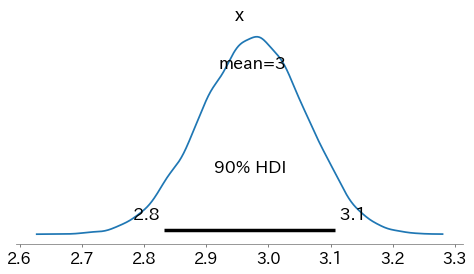

In [19]:
m = np.matmul(trace['theta'], weights)
df_mean = pd.DataFrame([np.mean(m)], columns=['期待値'])
df_mean[['HDI下限値', 'HDI上限値']] = pm.hdi(m, hdi_prob=threshold) 
display(df_mean)

print()

pm.plot_posterior(m, figsize=(8, 4), hdi_prob=threshold)